# Validation with other economic indicators

## Unemployment Rate

Primary source: FRED. Publicly available at https://fred.stlouisfed.org/series/UNRATE. We manually downloaded a sample that covers the same time period as the IPI, i.e., from 2010 to 2020. The unprocessed sample is saved under "../data/raw".

### Load Unemployment Data

In [2]:
# load Unemployment data
import pandas as pd
df_unempl = pd.read_csv("../data/raw/Unemployment_US.csv", parse_dates=["observation_date"])

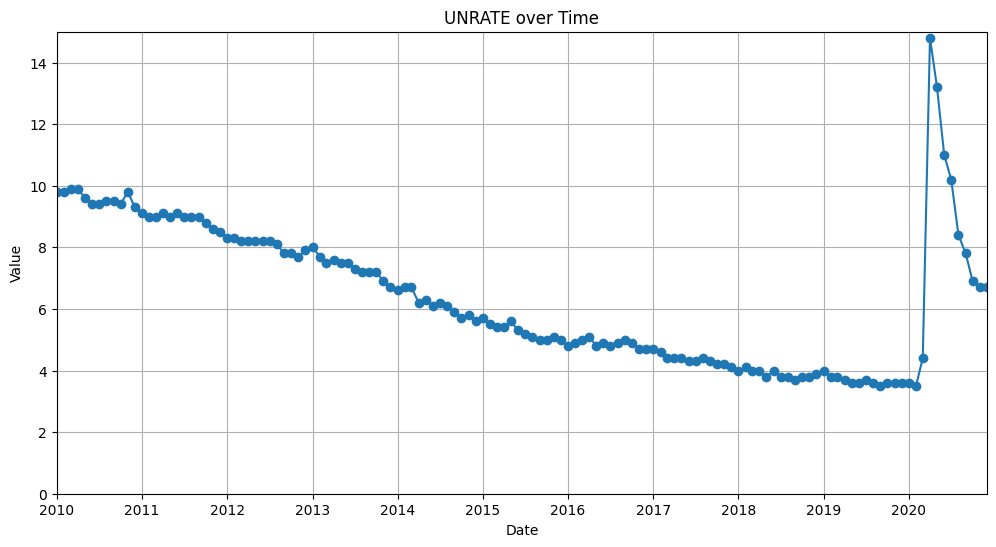

In [5]:
# plot unemployment over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_unempl["observation_date"], df_unempl["UNRATE"], marker="o", linestyle="-")
plt.title("UNRATE over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xlim(pd.Timestamp("2010-01-01"), pd.Timestamp("2020-12-01"))
plt.ylim(0,15)
plt.grid()

## 1.) Correlation between Unemployment Rate & Predicted IPI
In a first step, we look at the correlation of the unemployment rate and our predicted IPI. We would expect a negative correlation - when production goes up, unemployment often goes down. 

In [32]:
# Load IPI prediction file
df_preds_lda = pd.read_csv("../data/processed/lda_with_ipi_preds.csv", parse_dates=["month"])

# Rename date column of df_unempl to match
df_unempl.rename(columns={"observation_date": "month"}, inplace=True)

# Merge datasets
df_merged = df_preds_lda.merge(df_unempl, on="month", how="inner")


In [33]:
# Calculate correlation between IPI_predicted and UNRATE
from scipy.stats import pearsonr

corr, _ = pearsonr(df_merged["IPI_predicted"], df_merged["UNRATE"])
print(f"Correlation between IPI_predicted and Unemployment Rate: {corr:.3f}")


Correlation between IPI_predicted and Unemployment Rate: -0.452


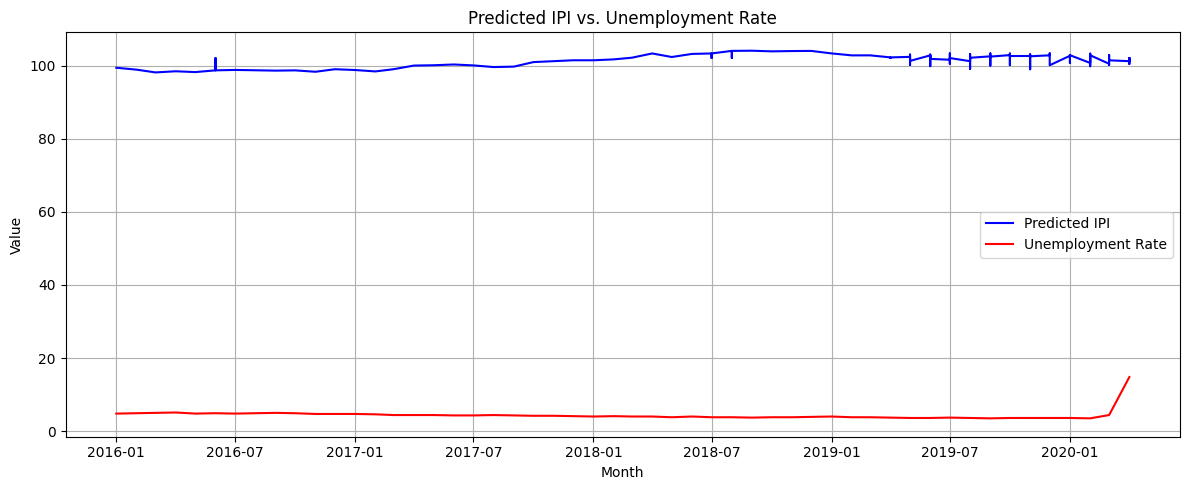

In [34]:
# Plot for Visual Validation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_merged["month"], df_merged["IPI_predicted"], label="Predicted IPI", color="blue")
plt.plot(df_merged["month"], df_merged["UNRATE"], label="Unemployment Rate", color="red")
plt.title("Predicted IPI vs. Unemployment Rate")
plt.xlabel("Month")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Run Regression 
import statsmodels.api as sm

X = sm.add_constant(df_merged["IPI_predicted"])  # Predictor with intercept
y = df_merged["UNRATE"]                          # Target (unemployment)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     323.2
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           1.74e-64
Time:                        14:52:58   Log-Likelihood:                -1471.7
No. Observations:                1259   AIC:                             2947.
Df Residuals:                    1257   BIC:                             2958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            25.3158      1.173     21.578

## 2.) Use Topic Shares to predict Unemployment Rate
Another way to validate our approach is to reuse the topic features to predict other targets. This shows whether the topics capture broader economic signals, not just the IPI. 

### Feature Engineering
We merge the unemployment data with the topic shares, following script 04-feature-engineering from our main analysis.

In [12]:
import pandas as pd

def create_features(monthly_topic_shares_by_publisher_path: str, features_path: str):
    # Load data
    topics = pd.read_csv(monthly_topic_shares_by_publisher_path)
    sentiment = pd.read_csv("../data/processed/monthly_sentiment_all.csv")
    unempl = pd.read_csv("../data/raw/Unemployment_US.csv")

    # Ensure date formats match
    topics['month'] = pd.to_datetime(topics['month'].astype(str))
    sentiment['month'] = pd.to_datetime(sentiment['date'].astype(str))
    unempl['month'] = pd.to_datetime(unempl['observation_date'].astype(str))

    # For topic data
    topics['month'] = pd.to_datetime(topics['month']).dt.to_period('M').dt.to_timestamp()

    # For sentiment data
    sentiment['month'] = pd.to_datetime(sentiment['date']).dt.to_period('M').dt.to_timestamp()

    # Merge on month + publication
    df = topics.merge(sentiment, on=['month', 'publication'], how='left')
    df = df.merge(unempl, on='month', how='left')

    # Drop rows with missing target (INDPRO)
    df = df.dropna(subset=['UNRATE'])

    # One-hot encode publisher
    df = pd.get_dummies(df, columns=['publication'], drop_first=True)

    # print preview of the final DataFrame
    cols = ['month', 'UNRATE', 'sentiment'] + [c for c in df.columns if c not in ('month', 'UNRATE', 'sentiment')]
    display(df[cols].head())

    # save features to csv
    df.to_csv(features_path, index=False)

LDA Features

In [13]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher.csv",
    features_path="../data/processed/unempl_features_lda_monthly.csv"
)

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False


BERTopic Features

In [14]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher_bertopic.csv",
    features_path="../data/processed/unempl_features_bertopic_monthly.csv"
)

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.096154,0.192308,0.153846,0.019231,0.134615,0.250000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.016807,0.042017,0.134454,0.050420,0.058824,0.588235,0.008403,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.100000,0.050000,0.016667,0.411111,0.266667,0.027778,0.016667,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.061674,0.154185,0.074890,0.061674,0.273128,0.189427,0.008811,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.036145,0.328313,0.307229,0.006024,0.015060,0.021084,0.000000,...,False,False,False,False,False,False,False,False,False,False


sLDA Features

In [15]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher_sLDA.csv",
    features_path="../data/processed/unempl_features_slda_monthly.csv"
)

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False


### Model Training
We employ the same models as used in our main analysis, following script 05-model-training.

In [18]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   -------- ------------------------------ 33.3/150.0 MB 176.6 MB/s eta 0:00:01
   --------------- ----------------------- 60.0/150.0 MB 152.9 MB/s eta 0:00:01
   ------------------------- ------------- 97.0/150.0 MB 154.8 MB/s eta 0:00:01
   ---------------------------------- --- 136.3/150.0 MB 161.2 MB/s eta 0:00:01
   -------------------------------------  149.9/150.0 MB 162.3 MB/s eta 0:00:01
   -------------------------------------- 150.0/150.0 MB 129.5 MB/s eta 0:00:00


In [20]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00


In [22]:
!pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
    --------------------------------------- 2.1/102.5 MB 16.8 MB/s eta 0:00:06
   - -------------------------------------- 4.2/102.5 MB 12.6 MB/s eta 0:00:08
   -- ------------------------------------- 6.3/102.5 MB 11.7 MB/s eta 0:00:09
   -- ------------------------------------- 7.3/102.5 MB 11.1 MB/s eta 0:00:09
   -- ------------------------------------- 7.3/102.5 MB 11.1 MB/s eta 0:00:09
   -- ------------------------------------- 7.3/102.5 MB 11.1 MB/s eta 0:00:09
   --- ------------------------------------ 9.4/102.5 MB 6.5 MB/s eta 0:00:15
   ---- ----------------------------------- 11.5/102.5 MB 6.9 MB/s eta 0:00:14
   ---- ----------------------------------- 12.6/102.5 MB 6.7 MB/s eta 0:00:14
   ----- ---------------------------------- 13.6/102.5 MB 6.8 MB/s eta 0:00:13
   ------ --------------------------------- 15.7/102.5 MB 6.9 MB/s eta 0:00:13
   ------ --------------------------------- 17.8/102.5 MB 7.2

In [ ]:
# Generalised Topic Model Training Script

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def train_topic_model(input_file: str, feature_prefix: str, model_save_path: str):
    # Load data
    df = pd.read_csv(input_file)

    # Preview
    cols = ['month', 'UNRATE', 'sentiment'] + [c for c in df.columns if c not in ('month', 'UNRATE', 'sentiment')]
    display(df[cols].head())

    # Define models and hyperparameters
    models_and_params = {
        'XGBoost': {
            'model': XGBRegressor(objective='reg:squarederror', random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            }
        },
        'LightGBM': {
            'model': LGBMRegressor(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'num_leaves': [31, 50]
            }
        },
        'CatBoost': {
            'model': CatBoostRegressor(verbose=0, random_state=42),
            'params': {
                'iterations': [100, 300],
                'learning_rate': [0.01, 0.1],
                'depth': [3, 5]
            }
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10],
                'min_samples_split': [2, 5]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0]
            }
        },
        'Lasso': {
            'model': Lasso(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0]
            }
        },
        'ElasticNet': {
            'model': ElasticNet(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            }
        },
        'BayesianRidge': {
            'model': BayesianRidge(),
            'params': {}
        },
        'SVR-RBF': {
            'model': SVR(kernel='rbf'),
            'params': {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto']
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 10],
                'weights': ['uniform', 'distance']
            }
        },
        'MLP': {
            'model': MLPRegressor(random_state=42, max_iter=500),
            'params': {
                'hidden_layer_sizes': [(50,), (100,)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001]
            }
        }
    }

    # Select features and target
    features = [col for col in df.columns if col.startswith(feature_prefix) or col.startswith('publication_')]
    features.append('sentiment')
    X = df[features]
    y = df['UNRATE']

    # Train-test split
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)
    best_models = []

    for name, mp in models_and_params.items():
        print(f"\n🔍 Tuning {name}...")
        grid = GridSearchCV(
            estimator=mp['model'],
            param_grid=mp['params'],
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            verbose=0
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        best_models.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Test RMSE': rmse
        })

    results_df = pd.DataFrame(best_models).sort_values(by='Test RMSE')
    print(results_df)

    # Get the best model
    best_idx = results_df['Test RMSE'].idxmin()
    best_name = results_df.loc[best_idx, 'Model']
    best_params = results_df.loc[best_idx, 'Best Params']

    # Final model instantiation and training
    if best_name == 'XGBoost':
        final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
    elif best_name == 'RandomForest':
        final_model = RandomForestRegressor(random_state=42, **best_params)
    elif best_name == 'GradientBoosting':
        final_model = GradientBoostingRegressor(random_state=42, **best_params)
    elif best_name == 'Ridge':
        final_model = Ridge(**best_params)
    elif best_name == 'ExtraTrees':
        final_model = ExtraTreesRegressor(random_state=42, **best_params)
    elif best_name == 'BayesianRidge':
        final_model = BayesianRidge(**best_params)
    elif best_name == 'Lasso':
        final_model = Lasso(random_state=42, **best_params)
    elif best_name == 'CatBoost':
        final_model = CatBoostRegressor(verbose=0, random_state=42, **best_params)
    elif best_name == "KNN":
        final_model = KNeighborsRegressor(**best_params)
    elif best_name == "SVR-RBF":
        final_model = SVR(**best_params) 
    else:
        raise ValueError(f"Unknown model: {best_name}")

    final_model.fit(X_train, y_train)
    joblib.dump(final_model, model_save_path)
    print(f"Saved best model ({best_name}) to {model_save_path}")

    # Plot results
    results_df.plot(x='Model', y='Test RMSE', kind='barh', legend=False, title='Model Comparison (Test RMSE)')
    plt.xlabel("RMSE (Lower is Better)")
    plt.tight_layout()
    plt.show()

    return results_df

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...
               Model                                        Best Params  \
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 300, 'n...   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
3       RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
11               KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
7              Lasso                                    {'alpha': 0.01}   
8         ElasticNet                

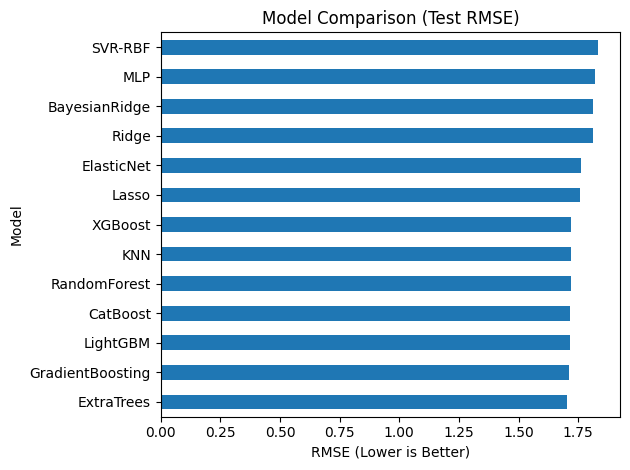

,Model,Best Params,Test RMSE
4,ExtraTrees,"{'max_depth': None, 'n_estimators': 300}",1.704072
5,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.710425
1,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 300, 'n...",1.713786
2,CatBoost,"{'depth': 5, 'iterations': 300, 'learning_rate...",1.717281
3,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n...",1.718652
11,KNN,"{'n_neighbors': 3, 'weights': 'uniform'}",1.718993
0,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.719975
7,Lasso,{'alpha': 0.01},1.755644
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",1.759452
6,Ridge,{'alpha': 0.1},1.810250


In [28]:
train_topic_model(
    input_file="../data/processed/unempl_features_lda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/unempl_best_model_lda.joblib"
)

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.096154,0.192308,0.153846,0.019231,0.134615,0.250000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.016807,0.042017,0.134454,0.050420,0.058824,0.588235,0.008403,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.100000,0.050000,0.016667,0.411111,0.266667,0.027778,0.016667,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.061674,0.154185,0.074890,0.061674,0.273128,0.189427,0.008811,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.036145,0.328313,0.307229,0.006024,0.015060,0.021084,0.000000,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...
               Model                                        Best Params  \
11               KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 100, 'n...   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
7              Lasso                                    {'alpha': 0.01}   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
3       RandomForest  {'max_depth': 

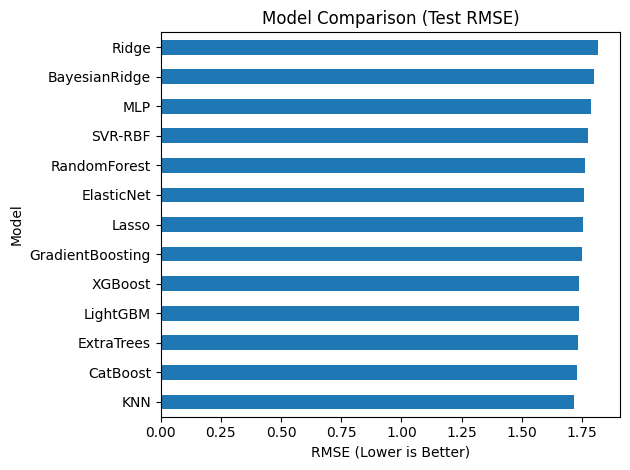

,Model,Best Params,Test RMSE
11,KNN,"{'n_neighbors': 3, 'weights': 'uniform'}",1.717392
2,CatBoost,"{'depth': 5, 'iterations': 300, 'learning_rate...",1.728303
4,ExtraTrees,"{'max_depth': None, 'n_estimators': 300}",1.735372
1,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",1.737997
0,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.739009
5,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.748485
7,Lasso,{'alpha': 0.01},1.755644
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",1.759299
3,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n...",1.764014
10,SVR-RBF,"{'C': 10, 'gamma': 'scale'}",1.773999


In [29]:
train_topic_model(
    input_file="../data/processed/unempl_features_bertopic_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/unempl_best_model_bertopic.joblib"
)

,month,UNRATE,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,4.8,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,4.8,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,4.8,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,4.8,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,4.8,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...
               Model                                        Best Params  \
10           SVR-RBF                        {'C': 10, 'gamma': 'scale'}   
1           LightGBM  {'learning_rate': 0.01, 'n_estimators': 300, '...   
11               KNN           {'n_neighbors': 5, 'weights': 'uniform'}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
12               MLP  {'activation':

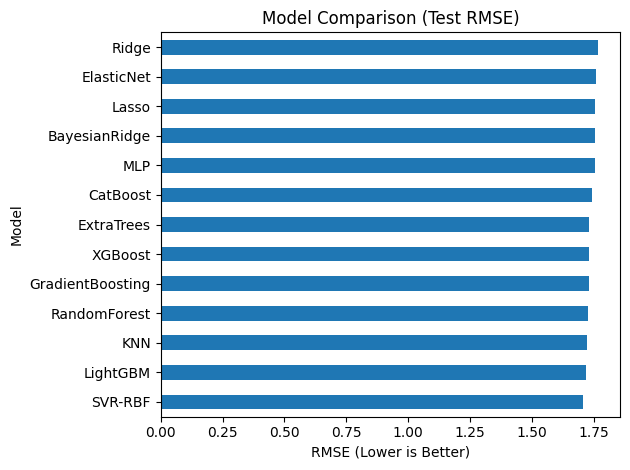

,Model,Best Params,Test RMSE
10,SVR-RBF,"{'C': 10, 'gamma': 'scale'}",1.706348
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 300, '...",1.720651
11,KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",1.723235
3,RandomForest,"{'max_depth': None, 'min_samples_split': 5, 'n...",1.725708
5,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.729262
0,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.730053
4,ExtraTrees,"{'max_depth': None, 'n_estimators': 300}",1.730552
2,CatBoost,"{'depth': 5, 'iterations': 300, 'learning_rate...",1.741360
12,MLP,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",1.754388
9,BayesianRidge,{},1.755634


In [30]:
train_topic_model(
    input_file="../data/processed/unempl_features_slda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/unempl_best_model_slda.joblib"
)

## 3.) Forecasting value-add
Do topic shares from news offer additional explanatory or predictive power for IPI beyond what traditional economic indicatores (like unemployment) already provide? To analyse the incremental validity of our approach, build two models: 
(i) Baseline model - predict INDPRO using UNRATE only
(ii) Full model - predict INDPRO using UNRATE + topic shares

We then compare the performance (e.g., RMSE) of the two models; if the full model performs better, the topic features add value. 

In [39]:
# Baseline: only unemployment and sentiment
X_baseline = df_merged[["UNRATE", "sentiment"]]

# Full feature set: topics + unemployment + sentiment
features_full = [col for col in df_merged.columns if col.startswith("topic_")]
features_full += ["UNRATE", "sentiment"]

X_full = df_merged[features_full]
y = df_merged["INDPRO"]

In [40]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, shuffle=False, test_size=0.2)
Xb_train, Xb_test = train_test_split(X_baseline, shuffle=False, test_size=0.2)[0:2]

# Fit both
model_baseline = Ridge().fit(Xb_train, yf_train)
model_full = Ridge().fit(Xf_train, yf_train)

# Predict
y_pred_baseline = model_baseline.predict(Xb_test)
y_pred_full = model_full.predict(Xf_test)

# Evaluate
print("RMSE (Baseline):", mean_squared_error(yf_test, y_pred_baseline, squared=False))
print("RMSE (Full):", mean_squared_error(yf_test, y_pred_full, squared=False))

print("R² (Baseline):", r2_score(yf_test, y_pred_baseline))
print("R² (Full):", r2_score(yf_test, y_pred_full))


RMSE (Baseline): 4.858315228806842
RMSE (Full): 4.841093438940109
R² (Baseline): -1.8085937166663495
R² (Full): -1.788717163115877


## GDP

Retrieved from: FRED. Publicly available at https://fred.stlouisfed.org/tags/series?t=gdp%3Bmonthly%3Breal&rt=real&ob=pv&od=desc. 
Primary source: Organization for Economic Co-opertation and Development (OECD), Composite Leading Indicators: Reference Series (GDP) Normalized for United States.
We manually downloaded a sample that covers the same time period as the IPI, i.e., from 2010 to 2020. The unprocessed sample is saved under "../data/raw".

### Load GDP Data

In [43]:
# load gdp data
import pandas as pd
df_gdp = pd.read_csv("../data/raw/Index_GDP_US.csv", parse_dates=["observation_date"])

# Rename column
df_gdp.rename(columns={"USALORSGPNOSTSAM": "GDP"}, inplace=True)

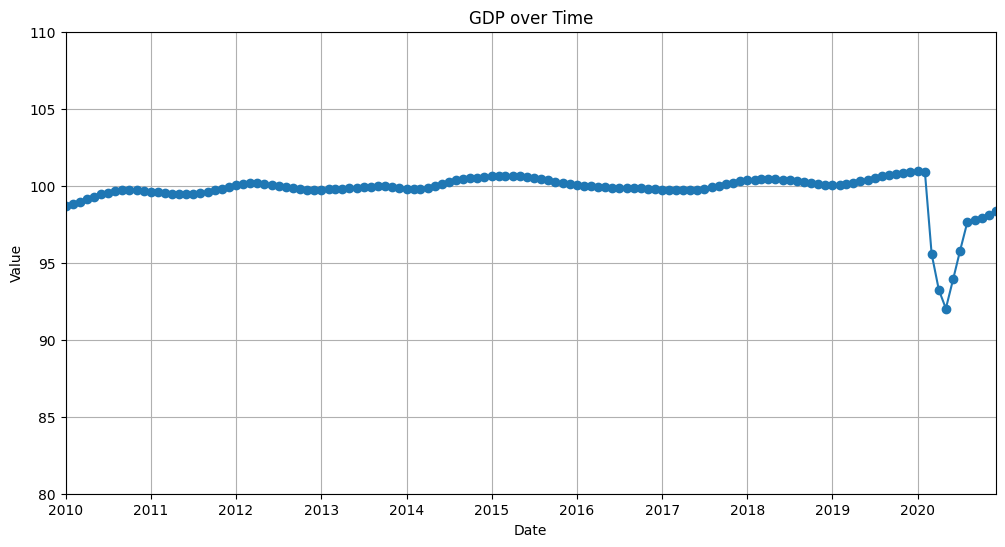

In [45]:
# plot gdp over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_gdp["observation_date"], df_gdp["GDP"], marker="o", linestyle="-")
plt.title("GDP over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xlim(pd.Timestamp("2010-01-01"), pd.Timestamp("2020-12-01"))
plt.ylim(80,110)
plt.grid()

## 1.) Correlation between GDP & Predicted IPI¶
In a first step, we look at the correlation of the GDP and our predicted IPI. We would expect a positive correlation - when production goes up, GDP often goes down.

In [53]:
# Load IPI prediction file
df_preds_lda = pd.read_csv("../data/processed/lda_with_ipi_preds.csv", parse_dates=["month"])

# Rename date column of df_gdp to match
df_gdp.rename(columns={"observation_date": "month"}, inplace=True)

# Merge datasets
df_merged = df_preds_lda.merge(df_gdp, on="month", how="inner")

In [54]:
# Calculate correlation between IPI_predicted and GDP
from scipy.stats import pearsonr

corr, _ = pearsonr(df_merged["IPI_predicted"], df_merged["GDP"])
print(f"Correlation between IPI_predicted and GDP: {corr:.3f}")

Correlation between IPI_predicted and GDP: 0.234


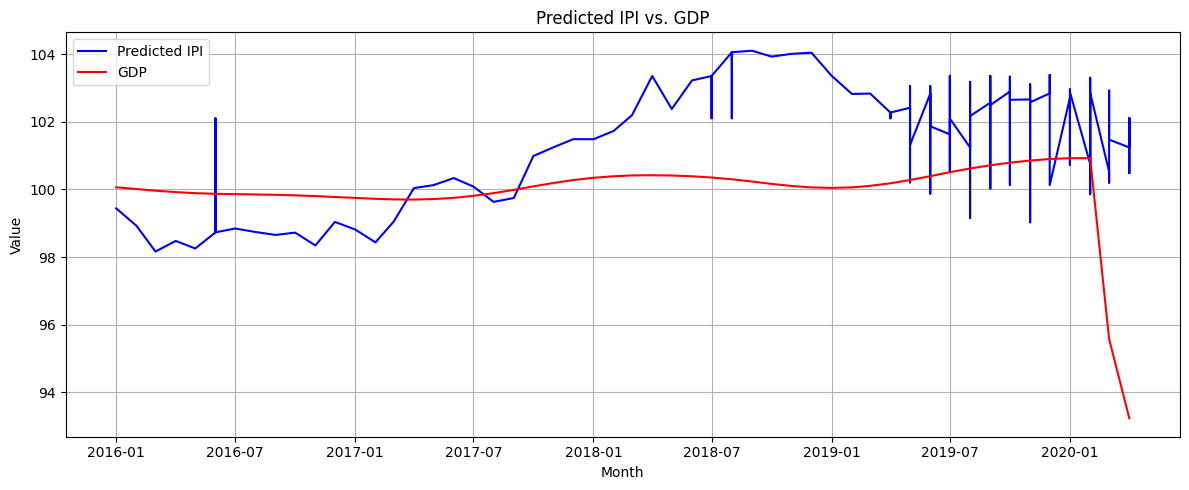

In [55]:
# Plot for Visual Validation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_merged["month"], df_merged["IPI_predicted"], label="Predicted IPI", color="blue")
plt.plot(df_merged["month"], df_merged["GDP"], label="GDP", color="red")
plt.title("Predicted IPI vs. GDP")
plt.xlabel("Month")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Run Regression 
import statsmodels.api as sm

X = sm.add_constant(df_merged["IPI_predicted"])  # Predictor with intercept
y = df_merged["GDP"]                          # Target (unemployment)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     72.62
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           4.44e-17
Time:                        15:33:39   Log-Likelihood:                -1495.4
No. Observations:                1259   AIC:                             2995.
Df Residuals:                    1257   BIC:                             3005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            89.8650      1.196     75.167

## 2.) Use Topic Shares to predict GDP
Another way to validate our approach is to reuse the topic features to predict other targets. This shows whether the topics capture broader economic signals, not just the IPI. 

### Feature Engineering
We merge the GDP data with the topic shares, following script 04-feature-engineering from our main analysis.

In [57]:
import pandas as pd

def create_features(monthly_topic_shares_by_publisher_path: str, features_path: str):
    # Load data
    topics = pd.read_csv(monthly_topic_shares_by_publisher_path)
    sentiment = pd.read_csv("../data/processed/monthly_sentiment_all.csv")
    gdp = pd.read_csv("../data/raw/Index_GDP_US.csv")

    # Ensure date formats match
    topics['month'] = pd.to_datetime(topics['month'].astype(str))
    sentiment['month'] = pd.to_datetime(sentiment['date'].astype(str))
    gdp['month'] = pd.to_datetime(gdp['observation_date'].astype(str))

    # For topic data
    topics['month'] = pd.to_datetime(topics['month']).dt.to_period('M').dt.to_timestamp()

    # For sentiment data
    sentiment['month'] = pd.to_datetime(sentiment['date']).dt.to_period('M').dt.to_timestamp()

    # Merge on month + publication
    df = topics.merge(sentiment, on=['month', 'publication'], how='left')
    df = df.merge(gdp, on='month', how='left')

    # Rename column
    df.rename(columns={"USALORSGPNOSTSAM": "GDP"}, inplace=True)
    
    # Drop rows with missing target (GDP)
    df = df.dropna(subset=['GDP'])

    # One-hot encode publisher
    df = pd.get_dummies(df, columns=['publication'], drop_first=True)

    # print preview of the final DataFrame
    cols = ['month', 'GDP', 'sentiment'] + [c for c in df.columns if c not in ('month', 'GDP', 'sentiment')]
    display(df[cols].head())

    # save features to csv
    df.to_csv(features_path, index=False)

LDA Features

In [58]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher.csv",
    features_path="../data/processed/gdp_features_lda_monthly.csv"
)

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False


BERTopic Features

In [59]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher_bertopic.csv",
    features_path="../data/processed/gdp_features_bertopic_monthly.csv"
)

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.096154,0.192308,0.153846,0.019231,0.134615,0.250000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.016807,0.042017,0.134454,0.050420,0.058824,0.588235,0.008403,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.100000,0.050000,0.016667,0.411111,0.266667,0.027778,0.016667,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.061674,0.154185,0.074890,0.061674,0.273128,0.189427,0.008811,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.036145,0.328313,0.307229,0.006024,0.015060,0.021084,0.000000,...,False,False,False,False,False,False,False,False,False,False


sLDA Features

In [60]:
create_features(
    monthly_topic_shares_by_publisher_path="../data/processed/monthly_topic_shares_by_publisher_sLDA.csv",
    features_path="../data/processed/gdp_features_slda_monthly.csv"
)

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False


### Model Training
We employ the same models as used in our main analysis, following script 05-model-training.

In [64]:
# Generalised Topic Model Training Script

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def train_topic_model(input_file: str, feature_prefix: str, model_save_path: str):
    # Load data
    df = pd.read_csv(input_file)

    # Preview
    cols = ['month', 'GDP', 'sentiment'] + [c for c in df.columns if c not in ('month', 'GDP', 'sentiment')]
    display(df[cols].head())

    # Define models and hyperparameters
    models_and_params = {
        'XGBoost': {
            'model': XGBRegressor(objective='reg:squarederror', random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            }
        },
        'LightGBM': {
            'model': LGBMRegressor(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'num_leaves': [31, 50]
            }
        },
        'CatBoost': {
            'model': CatBoostRegressor(verbose=0, random_state=42),
            'params': {
                'iterations': [100, 300],
                'learning_rate': [0.01, 0.1],
                'depth': [3, 5]
            }
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10],
                'min_samples_split': [2, 5]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0]
            }
        },
        'Lasso': {
            'model': Lasso(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0]
            }
        },
        'ElasticNet': {
            'model': ElasticNet(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            }
        },
        'BayesianRidge': {
            'model': BayesianRidge(),
            'params': {}
        },
        'SVR-RBF': {
            'model': SVR(kernel='rbf'),
            'params': {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto']
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 10],
                'weights': ['uniform', 'distance']
            }
        },
        'MLP': {
            'model': MLPRegressor(random_state=42, max_iter=500),
            'params': {
                'hidden_layer_sizes': [(50,), (100,)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001]
            }
        }
    }

    # Select features and target
    features = [col for col in df.columns if col.startswith(feature_prefix) or col.startswith('publication_')]
    features.append('sentiment')
    X = df[features]
    y = df['GDP']

    # Train-test split
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)
    best_models = []

    for name, mp in models_and_params.items():
        print(f"\n🔍 Tuning {name}...")
        grid = GridSearchCV(
            estimator=mp['model'],
            param_grid=mp['params'],
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            verbose=0
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        best_models.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Test RMSE': rmse
        })

    results_df = pd.DataFrame(best_models).sort_values(by='Test RMSE')
    print(results_df)

    # Get the best model
    best_idx = results_df['Test RMSE'].idxmin()
    best_name = results_df.loc[best_idx, 'Model']
    best_params = results_df.loc[best_idx, 'Best Params']

    # Final model instantiation and training
    if best_name == 'XGBoost':
        final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
    elif best_name == 'RandomForest':
        final_model = RandomForestRegressor(random_state=42, **best_params)
    elif best_name == 'GradientBoosting':
        final_model = GradientBoostingRegressor(random_state=42, **best_params)
    elif best_name == 'Ridge':
        final_model = Ridge(**best_params)
    elif best_name == 'ExtraTrees':
        final_model = ExtraTreesRegressor(random_state=42, **best_params)
    elif best_name == 'BayesianRidge':
        final_model = BayesianRidge(**best_params)
    elif best_name == 'Lasso':
        final_model = Lasso(random_state=42, **best_params)
    elif best_name == 'CatBoost':
        final_model = CatBoostRegressor(verbose=0, random_state=42, **best_params)
    elif best_name == "KNN":
        final_model = KNeighborsRegressor(**best_params)
    elif best_name == "SVR-RBF":
        final_model = SVR(**best_params) 
    else:
        raise ValueError(f"Unknown model: {best_name}")

    final_model.fit(X_train, y_train)
    joblib.dump(final_model, model_save_path)
    print(f"✅ Saved best model ({best_name}) to {model_save_path}")

    # Plot results
    results_df.plot(x='Model', y='Test RMSE', kind='barh', legend=False, title='Model Comparison (Test RMSE)')
    plt.xlabel("RMSE (Lower is Better)")
    plt.tight_layout()
    plt.show()

    return results_df

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

               Model                                        Best Params  \
5   GradientBoosting  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   
0            XGBoost  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   
3       RandomForest  {'max_depth': 10, 'min_samples_split': 5, 'n_e...   
4         ExtraTrees             {'max_depth': 10, 'n_estimators': 300}   
1           LightGBM  {'learning_rate': 0.01, 'n_estimators': 300, '...   
2           CatBoost  {'depth': 5, 'iterations': 100, 'learning_rate...   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
7              Lasso                                    {'alpha': 0.01}   
11               KNN         {'n_neighbors': 10, 'weights': 'distance'}   
6              Ridge                                     {'alpha': 1.0}   
9      BayesianRidge                                                 {}   
10           SVR-RBF                         {'C': 1, 'gamma': 'scale'}   
12               MLP  {'a

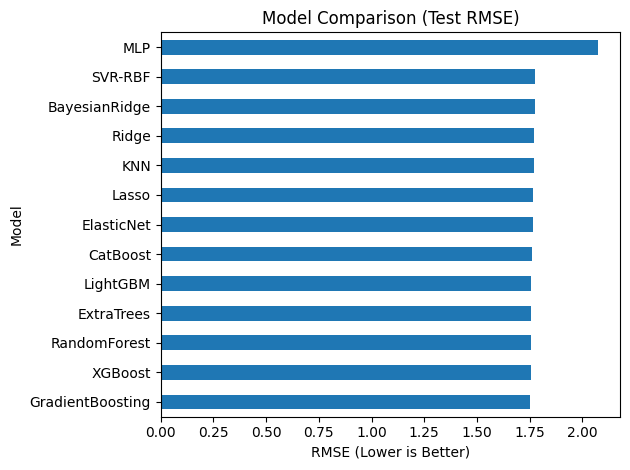

,Model,Best Params,Test RMSE
5,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.752517
0,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.755682
3,RandomForest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",1.755887
4,ExtraTrees,"{'max_depth': 10, 'n_estimators': 300}",1.756001
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 300, '...",1.758542
2,CatBoost,"{'depth': 5, 'iterations': 100, 'learning_rate...",1.760658
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",1.764810
7,Lasso,{'alpha': 0.01},1.764828
11,KNN,"{'n_neighbors': 10, 'weights': 'distance'}",1.769439
6,Ridge,{'alpha': 1.0},1.772483


In [65]:
train_topic_model(
    input_file="../data/processed/gdp_features_lda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/gdp_best_model_lda.joblib"
)

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.096154,0.192308,0.153846,0.019231,0.134615,0.250000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.016807,0.042017,0.134454,0.050420,0.058824,0.588235,0.008403,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.100000,0.050000,0.016667,0.411111,0.266667,0.027778,0.016667,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.061674,0.154185,0.074890,0.061674,0.273128,0.189427,0.008811,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.036145,0.328313,0.307229,0.006024,0.015060,0.021084,0.000000,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

               Model                                        Best Params  \
11               KNN         {'n_neighbors': 10, 'weights': 'distance'}   
2           CatBoost  {'depth': 3, 'iterations': 100, 'learning_rate...   
1           LightGBM  {'learning_rate': 0.01, 'n_estimators': 100, '...   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
0            XGBoost  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   
7              Lasso                                    {'alpha': 0.01}   
9      BayesianRidge                                                 {}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
4         ExtraTrees             {'max_depth': 10, 'n_estimators': 300}   
10           SVR-RBF                         {'C': 1, 'gamma': 'scale'}   
6              Ridge                                     {'alpha': 0.1}   
12               MLP  {'a

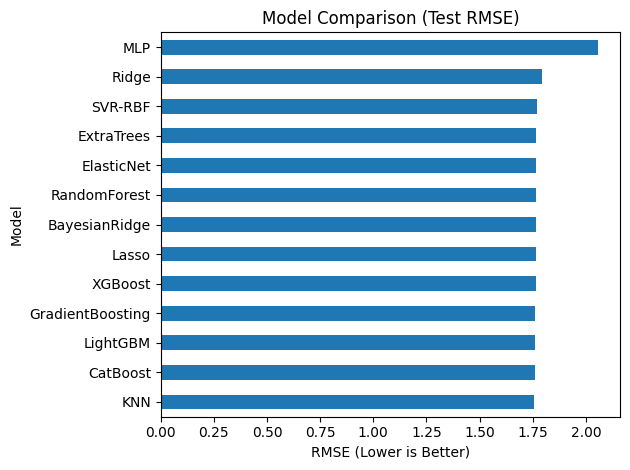

,Model,Best Params,Test RMSE
11,KNN,"{'n_neighbors': 10, 'weights': 'distance'}",1.756980
2,CatBoost,"{'depth': 3, 'iterations': 100, 'learning_rate...",1.760134
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 100, '...",1.761416
5,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.762824
0,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.763562
7,Lasso,{'alpha': 0.01},1.764828
9,BayesianRidge,{},1.764854
3,RandomForest,"{'max_depth': None, 'min_samples_split': 5, 'n...",1.764884
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",1.765210
4,ExtraTrees,"{'max_depth': 10, 'n_estimators': 300}",1.766513


In [66]:
train_topic_model(
    input_file="../data/processed/gdp_features_bertopic_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/gdp_best_model_bertopic.joblib"
)

,month,GDP,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,100.0642,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,100.0642,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,100.0642,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,100.0642,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,100.0642,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

               Model                                        Best Params  \
2           CatBoost  {'depth': 5, 'iterations': 100, 'learning_rate...   
10           SVR-RBF                         {'C': 1, 'gamma': 'scale'}   
11               KNN          {'n_neighbors': 10, 'weights': 'uniform'}   
0            XGBoost  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   
3       RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...   
1           LightGBM  {'learning_rate': 0.01, 'n_estimators': 100, '...   
4         ExtraTrees             {'max_depth': 10, 'n_estimators': 100}   
5   GradientBoosting  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
7              Lasso                                    {'alpha': 0.01}   
9      BayesianRidge                                                 {}   
6              Ridge                                    {'alpha': 10.0}   
12               MLP  {'a

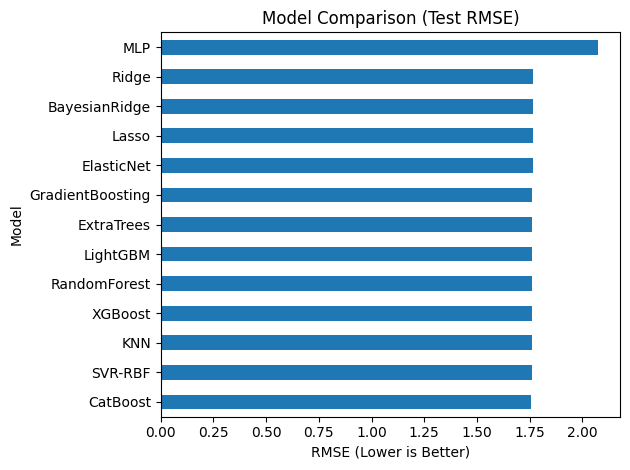

,Model,Best Params,Test RMSE
2,CatBoost,"{'depth': 5, 'iterations': 100, 'learning_rate...",1.758529
10,SVR-RBF,"{'C': 1, 'gamma': 'scale'}",1.758755
11,KNN,"{'n_neighbors': 10, 'weights': 'uniform'}",1.759530
0,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.760875
3,RandomForest,"{'max_depth': None, 'min_samples_split': 5, 'n...",1.761744
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 100, '...",1.762392
4,ExtraTrees,"{'max_depth': 10, 'n_estimators': 100}",1.762936
5,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.763172
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",1.764810
7,Lasso,{'alpha': 0.01},1.764828


In [67]:
train_topic_model(
    input_file="../data/processed/gdp_features_slda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/gdp_best_model_slda.joblib"
)

## 3.) Forecasting value-add
Do topic shares from news offer additional explanatory or predictive power for IPI beyond what traditional economic indicatores (like unemployment) already provide? To analyse the incremental validity of our approach, build two models: 
(i) Baseline model - predict INDPRO using GDP only
(ii) Full model - predict INDPRO using GDP + topic shares

We then compare the performance (e.g., RMSE) of the two models; if the full model performs better, the topic features add value. 

In [70]:
# Baseline: only GDP and sentiment
X_baseline = df_merged[["GDP", "sentiment"]]

# Full feature set: topics + unemployment + sentiment
features_full = [col for col in df_merged.columns if col.startswith("topic_")]
features_full += ["GDP", "sentiment"]

X_full = df_merged[features_full]
y = df_merged["GDP"]

In [71]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, shuffle=False, test_size=0.2)
Xb_train, Xb_test = train_test_split(X_baseline, shuffle=False, test_size=0.2)[0:2]

# Fit both
model_baseline = Ridge().fit(Xb_train, yf_train)
model_full = Ridge().fit(Xf_train, yf_train)

# Predict
y_pred_baseline = model_baseline.predict(Xb_test)
y_pred_full = model_full.predict(Xf_test)

# Evaluate
print("RMSE (Baseline):", mean_squared_error(yf_test, y_pred_baseline, squared=False))
print("RMSE (Full):", mean_squared_error(yf_test, y_pred_full, squared=False))

print("R² (Baseline):", r2_score(yf_test, y_pred_baseline))
print("R² (Full):", r2_score(yf_test, y_pred_full))


RMSE (Baseline): 0.03221503467561885
RMSE (Full): 0.033807655609824495
R² (Baseline): 0.9996661475852446
R² (Full): 0.9996323221843515
